In [1]:
import torch
import numpy as np
from typing import List, Tuple, Optional, Dict
from IPython.display import Image

print('PyTorch version:', torch.__version__)
print('NumPy version: ', np.__version__)

PyTorch version: 2.5.1
NumPy version:  2.0.1


## calculate the convolution output in 1d and 2d
* first rotate the input filter
* then construct the input vector with padding zeros
* calculate the number of traverse cells as num_traverse = (dim(padded input vector) - dim(filter)) // s + 1
* traverse the starting index of input vectors as (0, num_traverse * s, s)
* for each traversed index, do a element wise multiplication and append the total to save to the result list
* results are confirmed with np.convolve(x, w, mode='same') and scipy.signal.convolve2d for 1d and 2d, respectively

In [2]:
def conv1d(x: List[int], w: List[int], p: int=0, s: int=1):
    rs = []
    x = np.array(x)
    w_rotated = np.array(w[::-1])
    len_w = len(w)
    len_padded_x = 2 * p + len(x)

    if p > 0:
        pad = np.zeros(p)
    padded_x = np.concatenate([pad, x, pad])

    for i in range(0, ((len_padded_x - len_w) // s + 1) * s, s):
        total = np.sum(padded_x[i: i+len_w] * w_rotated)
        rs.append(total)

    return np.array(rs)

In [3]:
## Testing:
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

print('Conv1d Implementation:',
      conv1d(x, w, p=2, s=1))

print('Numpy Results:',
      np.convolve(x, w, mode='same')) 

Conv1d Implementation: [ 5. 14. 16. 26. 24. 34. 19. 22.]
Numpy Results: [ 5 14 16 26 24 34 19 22]


In [4]:
import scipy.signal
def conv2d(x: List[int], w: List[int], p=(0, 0), s=(0, 0)):
    original_x = np.array(x)
    w = np.array(w)[::-1, ::-1]

    n1, n2 = original_x.shape[0] + 2 * p[0], original_x.shape[1] + 2 * p[1]
    s1, s2 = s[0], s[1]
    rs = []

    padded_x = np.zeros((n1, n2))
    padded_x[p[0]: n1 - p[0], p[1]: n2-p[1]] = original_x
    
    for i in range(0, ((n1 - w.shape[0]) // s1 + 1) * s1, s1):
        rs.append([])
        for j in range(0, ((n2 - w.shape[1]) // s2 + 1) * s2, s2):
            total = np.sum(padded_x[i: i + w.shape[0], j: j + w.shape[1]] * w)
            rs[-1].append(total)

    return np.array(rs) 
    

In [5]:
X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]
print('Conv2d Implementation:\n',
    conv2d(X, W, p=(1, 1), s=(1, 1)))

print('SciPy Results:\n', scipy.signal.convolve2d(X, W, mode='same'))

Conv2d Implementation:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
SciPy Results:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


### np.concatenate() Method
* default axis for concatenate is 0 (rows)
* concat can happen when input np.arrays have all dimensions match except the dimension to concat
* For example a 2 by 2 array can concat with either a 2 by 1 (on axis 1) or 1 by 2 (on axis 0)

In [6]:
import numpy as np

a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6]])

print(f"shape of a is {a.shape}")
print(f"shape of b is {b.shape}")
print(f"shape of b.T is {b.T.shape}")

shape of a is (2, 2)
shape of b is (1, 2)
shape of b.T is (2, 1)


In [7]:
# Default behavior (axis=0) 2 by 2 concat with 1 by 2
result = np.concatenate((a, b), axis=0)
print(result)
# Output:
# [[1 2]
#  [3 4]
#  [5 6]]

# Concatenating along axis=1 (axis=1) 2 by 2 concat with 2 by 1
result = np.concatenate((a, b.T), axis=1)
print(result)
# Output:
# [[1 2 5]
#  [3 4 6]]

[[1 2]
 [3 4]
 [5 6]]
[[1 2 5]
 [3 4 6]]


### The output dimension of CNN is calculated by the following equation:
* n: dimension of input image
* p: padding size
* m: kernel size
* s: stride
* o: output dimension

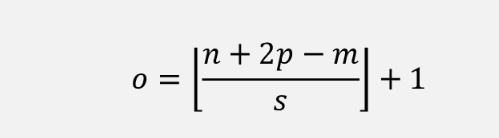

## Image processing in Pytorch

### Read image files

In [8]:
import torch
from torchvision.io import read_image

image = read_image('example-image.png')

print(f"image shape is {image.shape}")
print(f"number of channels is {image.shape[0]}")
print(f"image data type: {image.dtype}")

# print 3 channels, data points between 100 and 101 on width and height
print(image[:, 100:102, 100:102])     
      

image shape is torch.Size([3, 252, 221])
number of channels is 3
image data type: torch.uint8
tensor([[[179, 182],
         [180, 182]],

        [[134, 136],
         [135, 137]],

        [[110, 112],
         [111, 113]]], dtype=torch.uint8)


### Adding L2 regularization to conv2D and Linear layers
* for a conv2d layer of (input_channels=3, out_channels=5, kernel_size=5) with bias= True
  + each kernel has 5 by 5 dimension, coresponding to 25 parameters
  + each input channel has a kernel, and therefore, 3 input channels have 25 times 3 = 75 parameters
  + each set of input channels has a bias parameter, and therefore, each set of 3 input channels have 75 + 1 = 76 parameters
  + each output channel corresponds to one set of input channels (76 parameters) and therefore, 5 output channels have 76 by 5 = 380 parameters 

In [9]:
import torch.nn as nn
loss_fn = nn.BCELoss()
l2_lambda = 0.001
loss = loss_fn(torch.tensor([0.9]), torch.tensor([1.0]))

conv2d = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5)
l2_penalty = l2_lambda * sum([p.pow(2).sum() for p in conv2d.parameters()])
loss_with_penalty = loss + l2_penalty
print(loss_with_penalty)

linear = nn.Linear(10, 16)
l2_penalty = l2_lambda * sum([p.pow(2).sum() for p in linear.parameters()])
loss_with_penalty = loss + l2_penalty
print(loss_with_penalty)

tensor(0.1071, grad_fn=<AddBackward0>)
tensor(0.1112, grad_fn=<AddBackward0>)


In [10]:
# conv2d stores the parameters in a 2 element array.
# the first element stores the kernal parameters of dimension [5,3,5,5]
# the second element stores the bias if dimension [5]
ele = ([p for p in conv2d.parameters()])
print(f"len(ele)={len(ele)}")
print(f"dimension of ele[0]: {ele[0].shape}")
print(f"dimension of ele[1]: {ele[1].shape}")

len(ele)=2
dimension of ele[0]: torch.Size([5, 3, 5, 5])
dimension of ele[1]: torch.Size([5])


### Choosing loss functions for classifications
  + binary cross entropy (nn.BCELoss) uses probability after sigmoid transformation
  + BCEWithLogitsLoss uses logits directly
  + CrossEntropyLoss uses logits directly
  + NLLLoss uses probability after softmax transformation and then torch.log transformation

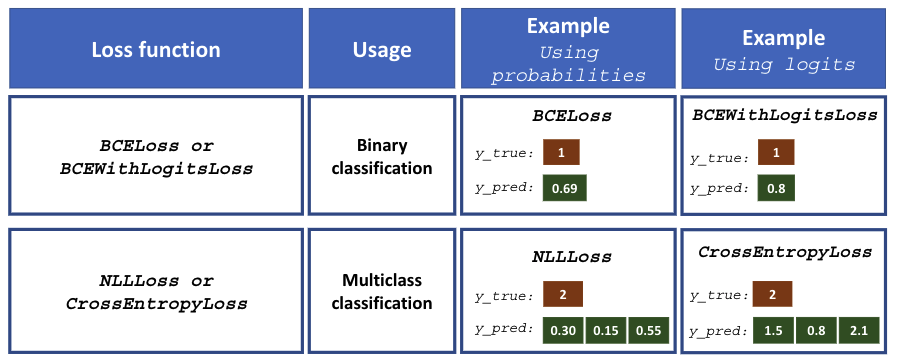

In [11]:
Image(filename='../figures/14_11.png', width=800)

In [12]:
# binary cross entropy
logits = torch.tensor([0.8])
targets = torch.tensor([1.0])
probas = torch.sigmoid(logits)
bce_loss_fn = nn.BCELoss()
bce_with_logits_fn = nn.BCEWithLogitsLoss()

print(f"loss by bce_loss_fn {bce_loss_fn(probas, targets):.4f}")
print(f"loss by bce_with_logits {bce_with_logits_fn(logits, targets):.4f}") 

loss by bce_loss_fn 0.3711
loss by bce_with_logits 0.3711


In [13]:
# cross entropy / softmax
logits = torch.tensor([[1.5, 0.8, 2.1]])
targets = torch.tensor([2])
probas = torch.softmax(logits, dim=1)
ce_loss_fn = nn.CrossEntropyLoss()
ce_with_logits_fn = nn.NLLLoss()

print(f"loss by ce_loss_fn {ce_loss_fn(logits, targets):.4f}")
print(f"loss by ce_with_logits {ce_with_logits_fn(torch.log(probas), targets):.4f}") 

loss by ce_loss_fn 0.5996
loss by ce_with_logits 0.5996


## Build CNN model for digit classification using MNIST dataset

### prepare train, validation and test datasets

In [14]:
from torch.utils.data import Subset
from torchvision.datasets import MNIST
from torchvision import transforms as transforms

In [15]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = MNIST("../data/", train=True, transform=transform)
data_test = MNIST("../data/", train=False, transform=transform)

In [16]:
data_validate = Subset(mnist_train, torch.arange(10000))
data_train = Subset(mnist_train, torch.arange(10000, len(mnist_train)))

### Build data loaders for training and validation datasets

In [17]:
from torch.utils.data import DataLoader

torch.manual_seed(1)
batch_size = 64
train_dl = DataLoader(data_train, batch_size, shuffle=True)
valid_dl = DataLoader(data_validate, batch_size, shuffle=True)

### Build a CNN multiple layer classifier
* the MNIST images only have one channel, with H by W = 28 by 28
* CNN model only cares about the sencond dimension of the input data.
  + the first dimension is batch dimension, which model will derive from input data
  + the second dimension is channel dimension, which need to be defined in model architecture
  + the third and fourth are height and width dimensions, which the model will derive from input data

In [18]:
import torch
import torch.nn as nn

model = nn.Sequential()
model.add_module("conv1", nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module("relu1", nn.ReLU())
model.add_module("maxpool1", nn.MaxPool2d(kernel_size=2))
model.add_module("conv2", nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module("relu2", nn.ReLU())
model.add_module("maxpool2", nn.MaxPool2d(kernel_size=2))
model.add_module("flatten", nn.Flatten())
                 

In [19]:
# test the final dimension after maxpool2 layer
input = torch.ones(4, 1, 28, 28)
output = model(input)

In [20]:
output.shape

torch.Size([4, 3136])

In [21]:
# add fully connected layer to convert to 1024 elements
model.add_module("fc1", nn.Linear(3136, 1024))
model.add_module("relu3", nn.ReLU())
model.add_module("dropout", nn.Dropout(p=0.5))
model.add_module("fc2", nn.Linear(1024, 10))

In [22]:
input = torch.ones(4, 1, 28, 28)
output = model(input)
print(output.shape)

torch.Size([4, 10])


### Train model

In [23]:
loss_fn = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 20
device = "cuda:0"
model.to(device)

def train(model, num_epochs, train_dl, valid_dl) -> List:
    loss_valid_hist = [0] * num_epochs
    loss_train_hist = [0] * num_epochs
    acc_valid_hist = [0] * num_epochs
    acc_train_hist = [0] * num_epochs
    
    
    for epoch in range(num_epochs):
        model.train()
        for batch_x, batch_y in train_dl:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
    
            pred = model(batch_x)
            loss = loss_fn(pred, batch_y)
            loss.backward()
    
            optimizer.step()
            loss_train_hist[epoch] += loss.item() * len(batch_y)
            is_correct = (torch.argmax(pred, dim=1) == batch_y).float()
            acc_train_hist[epoch] += is_correct.sum().cpu()
    
        loss_train_hist[epoch] /= len(train_dl.dataset)
        acc_train_hist[epoch] /= len(train_dl.dataset)
    
        model.eval()
        with torch.no_grad():
            for batch_x, batch_y in valid_dl:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)

                pred = model(batch_x)
                loss = loss_fn(pred, batch_y)
    
                loss_valid_hist[epoch] += loss.item() * len(batch_y)
                is_correct = (torch.argmax(pred, dim=1) == batch_y).float()
                acc_valid_hist[epoch] += is_correct.sum().cpu()
    
        loss_valid_hist[epoch] /= len(valid_dl.dataset)
        acc_valid_hist[epoch] /= len(valid_dl.dataset)
        print(f'Epoch {epoch+1} accuracy: {acc_train_hist[epoch]:.4f} val_accuracy: {acc_valid_hist[epoch]:.4f}')

    return loss_train_hist, loss_valid_hist, acc_train_hist, acc_valid_hist


In [24]:
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9489 val_accuracy: 0.9803
Epoch 2 accuracy: 0.9838 val_accuracy: 0.9872
Epoch 3 accuracy: 0.9893 val_accuracy: 0.9886
Epoch 4 accuracy: 0.9915 val_accuracy: 0.9886
Epoch 5 accuracy: 0.9933 val_accuracy: 0.9906
Epoch 6 accuracy: 0.9943 val_accuracy: 0.9904
Epoch 7 accuracy: 0.9953 val_accuracy: 0.9901
Epoch 8 accuracy: 0.9959 val_accuracy: 0.9914
Epoch 9 accuracy: 0.9966 val_accuracy: 0.9901
Epoch 10 accuracy: 0.9964 val_accuracy: 0.9896
Epoch 11 accuracy: 0.9970 val_accuracy: 0.9891
Epoch 12 accuracy: 0.9970 val_accuracy: 0.9913
Epoch 13 accuracy: 0.9974 val_accuracy: 0.9916
Epoch 14 accuracy: 0.9972 val_accuracy: 0.9928
Epoch 15 accuracy: 0.9979 val_accuracy: 0.9911
Epoch 16 accuracy: 0.9980 val_accuracy: 0.9911
Epoch 17 accuracy: 0.9977 val_accuracy: 0.9905
Epoch 18 accuracy: 0.9986 val_accuracy: 0.9915
Epoch 19 accuracy: 0.9985 val_accuracy: 0.9902
Epoch 20 accuracy: 0.9980 val_accuracy: 0.9898


In [25]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt

def plot_curves(history):
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(1, 2, 1)
    plt.plot(history[0], lw=4)
    plt.plot(history[1], lw=4)
    plt.legend(['Train loss', 'Validation loss'], fontsize=15)
    ax.set_xlabel('Epochs', size=15)
    
    ax = fig.add_subplot(1, 2, 2)
    
    plt.plot(history[2], lw=4)
    plt.plot(history[3], lw=4)
    plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
    ax.set_xlabel('Epochs', size=15)

    

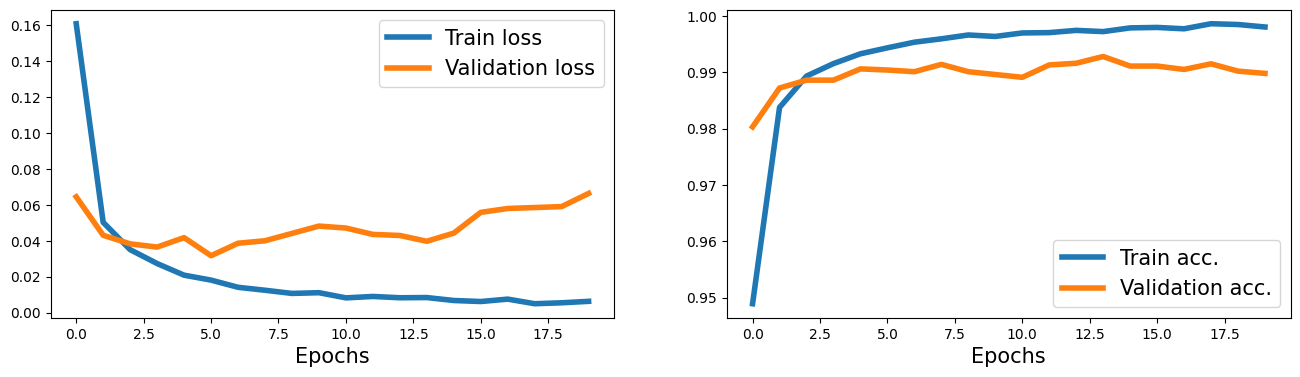

In [26]:
plot_curves(hist)

In [27]:
data_test[0][0].shape
data_test[0][1]

7

### plot test data performance

In [28]:
# move model to cpu
model_cpu = model.cpu()
pred = model_cpu(data_test.data.unsqueeze(1)/255)
is_correct = (torch.argmax(pred, dim=1) == data_test.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}') 


Test accuracy: 0.9931


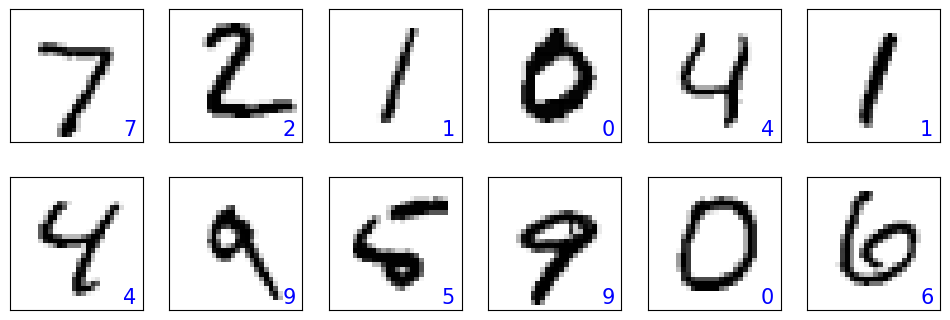

In [29]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = data_test[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1)) # alternatively: mnist_test_dataset.data[i].float()
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
    
#plt.savefig('figures/14_14.png')
plt.show()

## classification from face images using CNN

### Prepare and load the CelebA dataset

In [30]:
import torchvision 

image_path = '../data/'
celeba_train_dataset = torchvision.datasets.CelebA(image_path, split='train', target_type='attr', download=False)
celeba_valid_dataset = torchvision.datasets.CelebA(image_path, split='valid', target_type='attr', download=False)
celeba_test_dataset = torchvision.datasets.CelebA(image_path, split='test', target_type='attr', download=False)

print('Train set:', len(celeba_train_dataset))
print('Validation set:', len(celeba_valid_dataset))
print('Test set:', len(celeba_test_dataset))

Train set: 162770
Validation set: 19867
Test set: 19962


In [31]:
celeba_train_dataset[0]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218>,
 tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
         1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1]))

### Image transformation and augmentation
* the images are in PIL format (H, W, C)
* apply random crop, random flip and resize transformations in pipeline
  + demonstrate the transformations from random crop, random flip to resize by showing the images
  + build the transforms.Compose to pipeline for training data

#### demonstrate several transformations

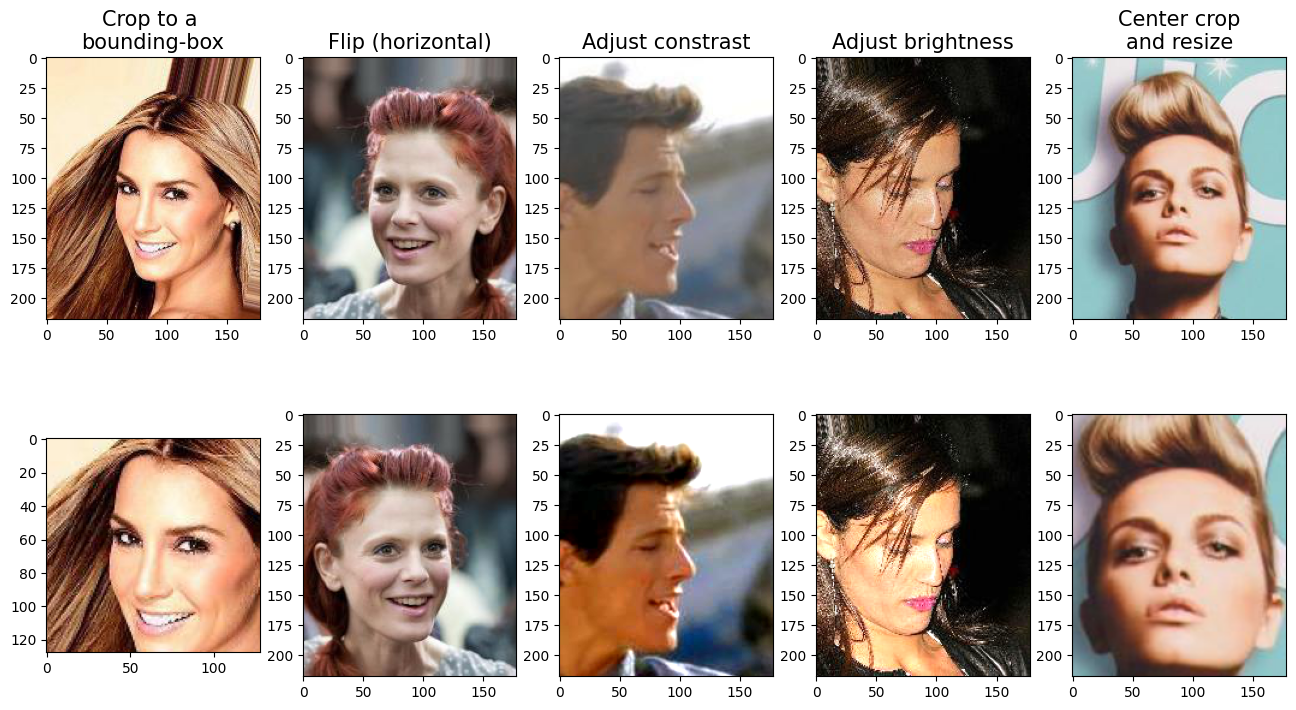

In [32]:
# show images. Notice the image format is in H, W, C PIL format
import matplotlib.pyplot as plt

from torchvision import transforms 

## take 5 examples

fig = plt.figure(figsize=(16, 8.5))

## Column 1: cropping to a bounding-box
ax = fig.add_subplot(2, 5, 1)
img, attr = celeba_train_dataset[0]
ax.set_title('Crop to a \nbounding-box', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 6)
img_cropped = transforms.functional.crop(img, 50, 20, 128, 128)
ax.imshow(img_cropped)

## Column 2: flipping (horizontally)
ax = fig.add_subplot(2, 5, 2)
img, attr = celeba_train_dataset[1]
ax.set_title('Flip (horizontal)', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 7)
img_flipped = transforms.functional.hflip(img)
ax.imshow(img_flipped)

## Column 3: adjust contrast
ax = fig.add_subplot(2, 5, 3)
img, attr = celeba_train_dataset[2]
ax.set_title('Adjust constrast', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 8)
img_adj_contrast = transforms.functional.adjust_contrast(img, contrast_factor=2)
ax.imshow(img_adj_contrast)

## Column 4: adjust brightness
ax = fig.add_subplot(2, 5, 4)
img, attr = celeba_train_dataset[3]
ax.set_title('Adjust brightness', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 9)
img_adj_brightness = transforms.functional.adjust_brightness(img, brightness_factor=1.3)
ax.imshow(img_adj_brightness)

## Column 5: cropping from image center 
ax = fig.add_subplot(2, 5, 5)
img, attr = celeba_train_dataset[4]
ax.set_title('Center crop\nand resize', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 10)
img_center_crop = transforms.functional.center_crop(img, [0.7*218, 0.7*178])
img_resized = transforms.functional.resize(img_center_crop, size=(218, 178))
ax.imshow(img_resized)
 
# plt.savefig('figures/14_14.png', dpi=300)
plt.show()

#### demonstrate the random crop, random flip and resize transformation pipeline
* set title for the first row images
* traverse training dataset and only show the first 3 images

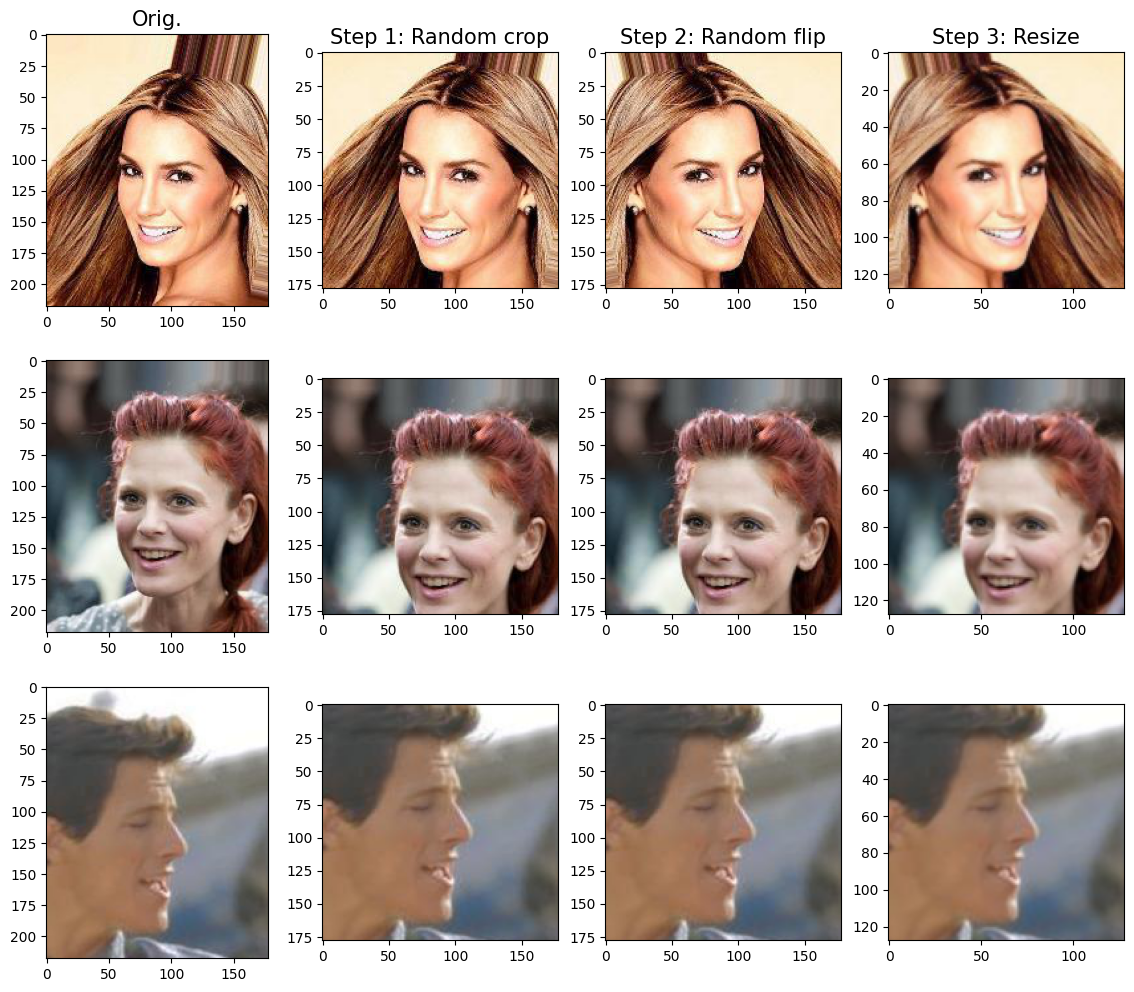

In [33]:
torch.manual_seed(1)

fig = plt.figure(figsize=(14, 12))

for i, (img, attr) in enumerate(celeba_train_dataset):
    ax = fig.add_subplot(3, 4, i*4+1)
    ax.imshow(img)
    if i == 0:
        ax.set_title('Orig.', size=15)
        
    ax = fig.add_subplot(3, 4, i*4+2)
    img_transform = transforms.Compose([transforms.RandomCrop([178, 178])])
    img_cropped = img_transform(img)
    ax.imshow(img_cropped)

    # set title for the first images
    if i == 0:
        ax.set_title('Step 1: Random crop', size=15)

    ax = fig.add_subplot(3, 4, i*4+3)
    img_transform = transforms.Compose([transforms.RandomHorizontalFlip()])
    img_flip = img_transform(img_cropped)
    ax.imshow(img_flip)
    if i == 0:
        ax.set_title('Step 2: Random flip', size=15)

    ax = fig.add_subplot(3, 4, i*4+4)
    img_resized = transforms.functional.resize(img_flip, size=(128, 128))
    ax.imshow(img_resized)
    if i == 0:
        ax.set_title('Step 3: Resize', size=15)
    
    if i == 2:
        break
        
# plt.savefig('figures/14_15.png', dpi=300)
plt.show()

#### Construct tranformers for training, validation and test datasets

In [34]:
from torch.utils.data import DataLoader, Subset
import torchvision.transforms

get_smile = lambda att: att[31]
image_path = "../data/"

transform_train = transforms.Compose([
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
    ])

transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

celeba_train_dataset = torchvision.datasets.CelebA(image_path, 
                                                   split='train', 
                                                   target_type='attr', 
                                                   download=False,
                                                   transform=transform_train,
                                                   target_transform=get_smile                                                   
                                                  )
train_ds = Subset(celeba_train_dataset, torch.arange(16000))

celeba_valid_dataset = torchvision.datasets.CelebA(image_path,
                                                   split='valid', 
                                                   target_type='attr', 
                                                   download=False,
                                                   transform=transform,
                                                   target_transform=get_smile
                                                  )
valid_ds = Subset(celeba_valid_dataset, torch.arange(1000))

celeba_test_dataset = torchvision.datasets.CelebA(image_path, 
                                                  split='test', 
                                                  target_type='attr', 
                                                  download=False,
                                                  transform=transform,
                                                  target_transform=get_smile
                                                 )
    


In [35]:
batch_size = 64

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(celeba_test_dataset, batch_size=batch_size, shuffle=False)


### Build model

#### Check dimensions of image
* the input images are of (C, H, W) = (3, 64, 64)
* build model starting from input channels of 3

In [36]:
x_batch, y_batch = next(iter(train_dl))
print(x_batch.shape, y_batch.shape)

torch.Size([64, 3, 64, 64]) torch.Size([64])


In [37]:
import torch.nn as nn

model = nn.Sequential()
model.add_module("conv1", nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module("relu1", nn.ReLU())
model.add_module("pool1", nn.MaxPool2d(kernel_size=2))
model.add_module("dropout1", nn.Dropout(p=0.5))

model.add_module("conv2", nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module("relu2", nn.ReLU())
model.add_module("pool2", nn.MaxPool2d(kernel_size=2))
model.add_module("dropout2", nn.Dropout(p=0.5))

model.add_module("conv3", nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module("relu3", nn.ReLU())
model.add_module("pool3", nn.MaxPool2d(kernel_size=2))

model.add_module("conv4", nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module("relu4", nn.ReLU())
model.add_module("pool4", nn.AvgPool2d(kernel_size=8))

model.add_module("flatten", nn.Flatten())
model.add_module("fc", nn.Linear(256, 1))
model.add_module("sigmoid", nn.Sigmoid())

input = torch.ones(2, 3, 64, 64)
output = model(input)
print(output.shape)


torch.Size([2, 1])


### Train model

In [38]:
def train_binary_classifier(model, num_epochs, train_dl, valid_dl) -> List:
    loss_valid_hist = [0] * num_epochs
    loss_train_hist = [0] * num_epochs
    acc_valid_hist = [0] * num_epochs
    acc_train_hist = [0] * num_epochs
    
    
    for epoch in range(num_epochs):
        model.train()
        for batch_x, batch_y in train_dl:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
    
            pred = model(batch_x)[:, 0]
            loss = loss_fn(pred, batch_y.float())
            loss.backward()
    
            optimizer.step()
            loss_train_hist[epoch] += loss.item() * len(batch_y)
            is_correct = ((pred >= 0.5).float() == batch_y).float()
            acc_train_hist[epoch] += is_correct.sum().cpu()
    
        loss_train_hist[epoch] /= len(train_dl.dataset)
        acc_train_hist[epoch] /= len(train_dl.dataset)
    
        model.eval()
        with torch.no_grad():
            for batch_x, batch_y in valid_dl:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)

                pred = model(batch_x)[:, 0]
                loss = loss_fn(pred, batch_y.float())
    
                loss_valid_hist[epoch] += loss.item() * len(batch_y)
                is_correct = ((pred >= 0.5).float() == batch_y).float()
                acc_valid_hist[epoch] += is_correct.sum().cpu()
    
        loss_valid_hist[epoch] /= len(valid_dl.dataset)
        acc_valid_hist[epoch] /= len(valid_dl.dataset)
        print(f'Epoch {epoch+1} accuracy: {acc_train_hist[epoch]:.4f} val_accuracy: {acc_valid_hist[epoch]:.4f}')

    return loss_train_hist, loss_valid_hist, acc_train_hist, acc_valid_hist


In [39]:
device = "cuda:0"
model.to(device)

loss_fn = nn.BCELoss()
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

num_epochs = 30
hist = train_binary_classifier(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.5197 val_accuracy: 0.5140
Epoch 2 accuracy: 0.5186 val_accuracy: 0.5340
Epoch 3 accuracy: 0.5363 val_accuracy: 0.5680
Epoch 4 accuracy: 0.5679 val_accuracy: 0.5770
Epoch 5 accuracy: 0.5786 val_accuracy: 0.5850
Epoch 6 accuracy: 0.5944 val_accuracy: 0.5560
Epoch 7 accuracy: 0.6208 val_accuracy: 0.5780
Epoch 8 accuracy: 0.6336 val_accuracy: 0.6000
Epoch 9 accuracy: 0.6479 val_accuracy: 0.6030
Epoch 10 accuracy: 0.6604 val_accuracy: 0.6710
Epoch 11 accuracy: 0.6726 val_accuracy: 0.6260
Epoch 12 accuracy: 0.6919 val_accuracy: 0.7020
Epoch 13 accuracy: 0.7222 val_accuracy: 0.7560
Epoch 14 accuracy: 0.7614 val_accuracy: 0.8090
Epoch 15 accuracy: 0.7979 val_accuracy: 0.8180
Epoch 16 accuracy: 0.8199 val_accuracy: 0.8260
Epoch 17 accuracy: 0.8331 val_accuracy: 0.8660
Epoch 18 accuracy: 0.8450 val_accuracy: 0.8650
Epoch 19 accuracy: 0.8499 val_accuracy: 0.8610
Epoch 20 accuracy: 0.8561 val_accuracy: 0.8610
Epoch 21 accuracy: 0.8637 val_accuracy: 0.8670
Epoch 22 accuracy: 0.8

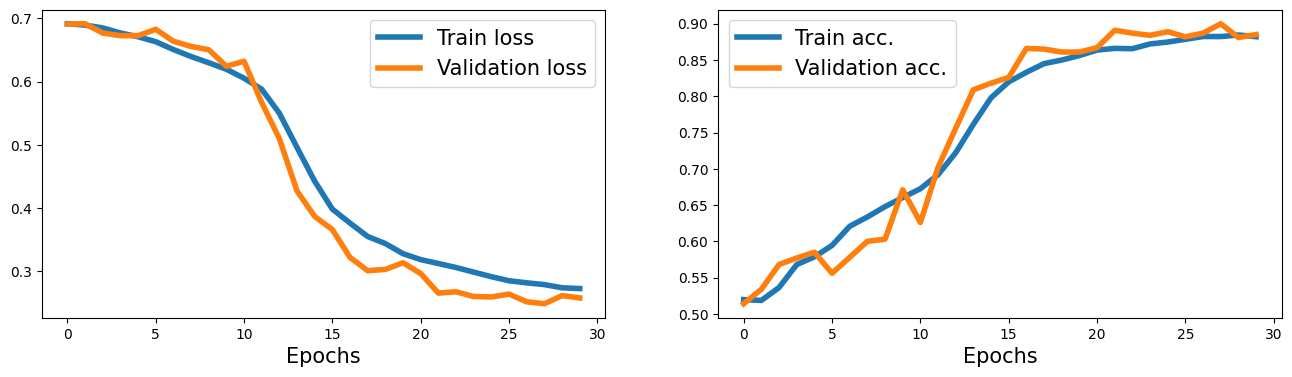

In [40]:
 plot_curves(hist)

In [41]:
accuracy_test = 0

model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        x_batch = x_batch.to(device) 
        y_batch = y_batch.to(device) 
        pred = model(x_batch)[:, 0]
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum().cpu()
 
accuracy_test /= len(test_dl.dataset)
        
print(f'Test accuracy: {accuracy_test:.4f}') 

Test accuracy: 0.9008


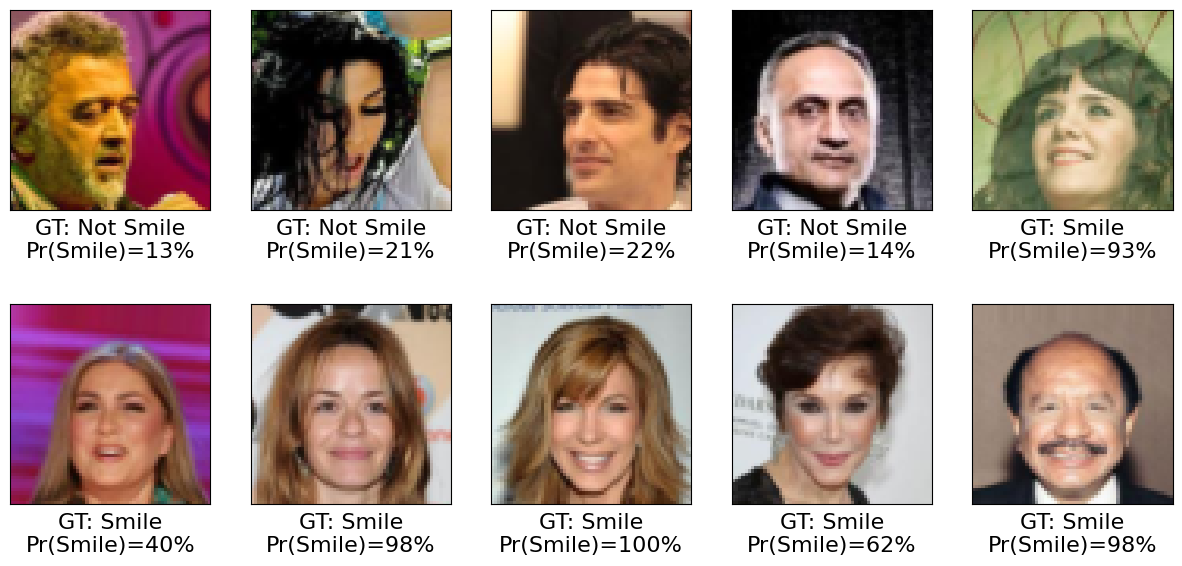

In [42]:
pred = model(x_batch)[:, 0] * 100

fig = plt.figure(figsize=(15, 7))
for j in range(10, 20):
    ax = fig.add_subplot(2, 5, j-10+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(x_batch[j].cpu().permute(1, 2, 0))
    if y_batch[j] == 1:
        label = 'Smile'
    else:
        label = 'Not Smile'
    ax.text(
        0.5, -0.15, 
        f'GT: {label:s}\nPr(Smile)={pred[j]:.0f}%', 
        size=16, 
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes)
    
#plt.savefig('figures/figures-14_18.png', dpi=300)
plt.show()